#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import time
import gif
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from scipy.optimize import linear_sum_assignment as linear_assignment
import os.path as osp

import motmetrics as mm
mm.lap.default_solver = 'lap'
%matplotlib inline


In [6]:
root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [7]:
from mot.data.data_track import MOT16Sequences
from mot.data.data_obj_detect import MOT16ObjDetect
from mot.models.object_detector import FRCNN_FPN
from mot.tracker.advanced import MPNTracker
from mot.eval import evaluate_mot_accums, get_mot_accum, evaluate_obj_detect
from mot.models.gnn import BipartiteNeuralMessagePassingLayer, SimilarityNet
from mot.visualize import plot_sequence, collect_frames_for_gif
from market.models import build_model



## Configuration

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = "cpu"


# Multi-object tracking

## Configuration

In [9]:
seed = 12345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


## load pretrained

In [12]:
# Define our model, and init
similarity_net = SimilarityNet(
    node_dim=32,
    edge_dim=64,
    reid_dim=512,
    edges_in_dim=6,
    num_steps=10,
).to(device)


In [14]:
best_ckpt = torch.load(
    osp.join(root_dir, "models", "best_ckpt.pth"),
    map_location=lambda storage, loc: storage,
)
similarity_net.load_state_dict(best_ckpt)
MAX_PATIENCE = 20

tracker = MPNTracker(
    similarity_net=similarity_net.eval(),
    obj_detect=None,
    reid_model=None,
    patience=MAX_PATIENCE,
)


In [15]:
val_sequences = MOT16Sequences(
    "MOT16-val2", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
)
train_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_train_2.pth")
)


In [16]:
output_dir = None
#####
db = train_db
time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    # break
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    # data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    with torch.no_grad():
        # for i, frame in enumerate(tqdm(data_loader)):
        for frame in db[str(seq)]:
            tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print("No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums,
        [str(s) for s in val_sequences if not s.no_gt],
        generate_overall=True,
    )


Tracking: MOT16-02
Tracks found: 107
Runtime for MOT16-02: 3.9 s.
Tracking: MOT16-11
Tracks found: 85
Runtime for MOT16-11: 3.8 s.
Runtime for all sequences: 7.7 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
MOT16-02 47.8% 67.9% 36.9% 52.2% 96.1%  62 11 38 13 390  8873  97  222 49.6% 0.096  56  49  11
MOT16-11 68.0% 74.9% 62.2% 80.2% 96.6%  75 44 24  7 266  1871  44   90 76.9% 0.083  38  15  14
OVERALL  55.4% 71.0% 45.4% 61.7% 96.3% 137 55 62 20 656 10744 141  312 58.8% 0.090  94  64  25


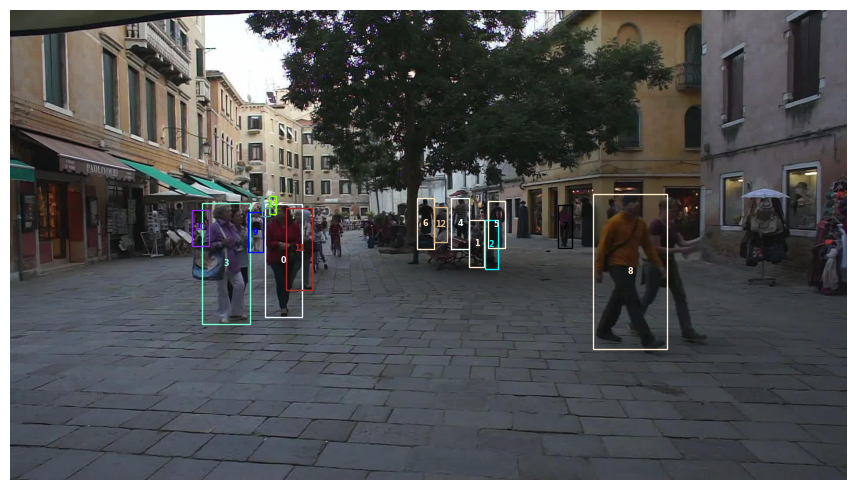

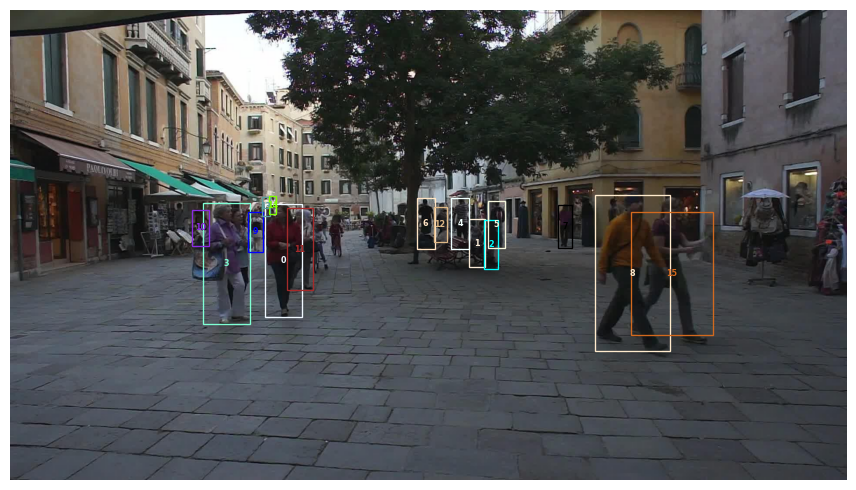

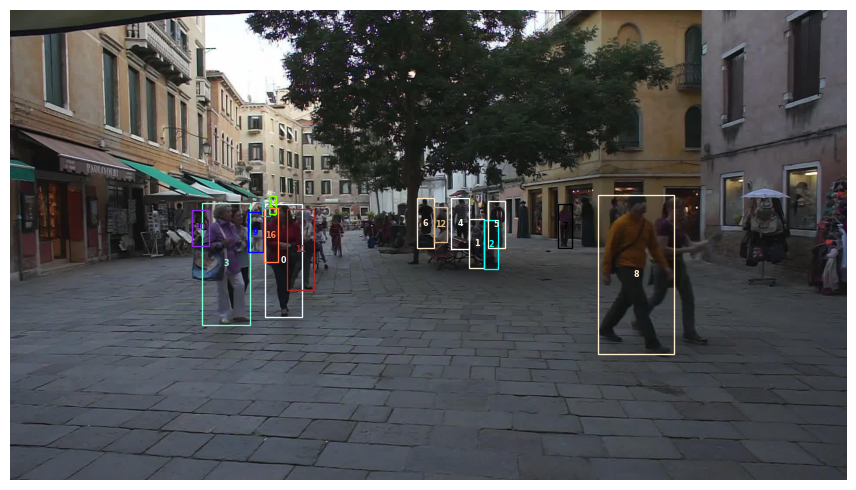

In [57]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in val_sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)


# create gif

In [116]:
gif.options.matplotlib["dpi"] = 70
gif.options.matplotlib["bbox_inches"] = 'tight'
gif.options.matplotlib["pad_inches"] = 0.0


In [117]:
seq_name = "MOT16-02"
sequence = [s for s in val_sequences if str(s) == seq_name][0]
tracker_seq_res = results_seq[seq_name]


In [ ]:
frames = collect_frames_for_gif(sequence, tracker_seq_res)

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
dst_path_gif = os.path.join(root_dir, "output/figs/MOT16-02-result.gif")
gif.save(frames, dst_path_gif, duration=50)
